In [1]:
%load_ext autoreload

In [6]:
%autoreload

from numpy      import *
from physics    import * 
from TLA        import *
from structform import *
from spectrum   import *
from lowengphotspec import *
from astropy.io import fits

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('tableau10.mplstyle')

# Low Energy Photon Deposition

## Importing Spectra and Plotting

In [7]:
hdulist = fits.open('testData/logE12.767_z2747_orig.fits', memmap=True)
rs = hdulist[1].data.REDSHIFT[0]
eng = hdulist[1].data.ENERGY[0]
lowengphot = hdulist[1].data.LOWENGPHOT[0]
lowengphot_elementgrid = hdulist[1].data.LOWENGPHOT_ELEMENTGRID[0]
lowerBound = hdulist[1].data.LOWERBOUND[0]
hdulist.close()

atoms = ['H0','He0','He1']

lowEngPhotSpec = Spectra(rs, eng, [Spectrum(eng,spec,rs) for spec,rs in zip(lowengphot,rs)])
lowEngPhotAtomSpec = ({atoms[i]:Spectra(rs, eng, [Spectrum(eng,spec[i,:],rs) 
                                                  for spec,rs in zip(lowengphot_elementgrid,rs)])
                       for i in arange(3)
                       })


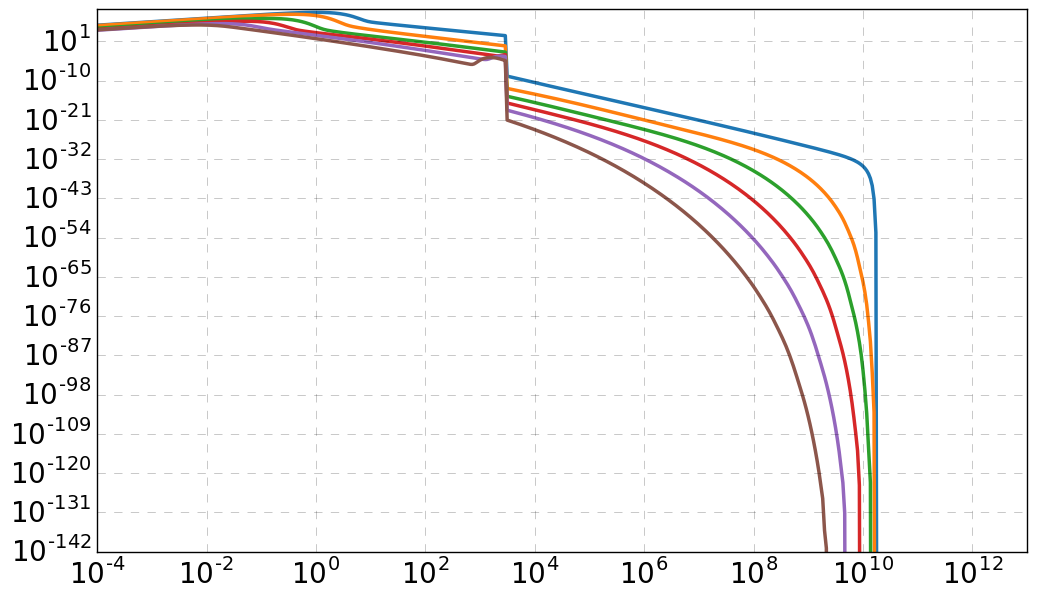

In [8]:
lowEngPhotSpec.plot((2,6000),step=1000)
plt.xscale('log')
plt.yscale('log')

3377.50464772


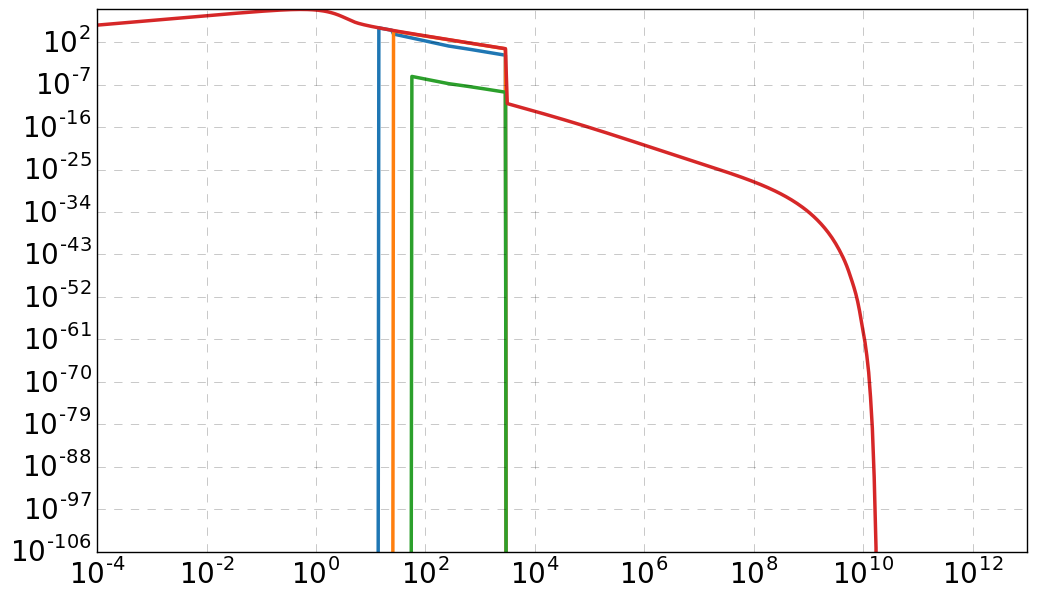

In [9]:
plt.figure(2)
testInd = 650
lowEngPhotAtomSpec['H0'].plot(testInd)
lowEngPhotAtomSpec['He0'].plot(testInd)
lowEngPhotAtomSpec['He1'].plot(testInd)
lowEngPhotSpec.plot(testInd)
plt.xscale('log')
plt.yscale('log')


print(lowerBound[20])

In [10]:
recfast = loadtxt('testData/recfast_standard.txt')

xe = interp(rs,flipud(recfast[:,0]),flipud(recfast[:,1]))
xH = interp(rs,flipud(recfast[:,0]),flipud(recfast[:,2]))

lowEngPhotAtomSpectrum = {atom:lowEngPhotAtomSpec[atom].spectrumList[testInd] for atom in atoms}

ionPhotSpec = getionphotspec(lowerBound[testInd], xH[testInd], xe[testInd], 1e-3, 
                             lowEngPhotSpec.spectrumList[testInd], lowEngPhotAtomSpectrum)

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00

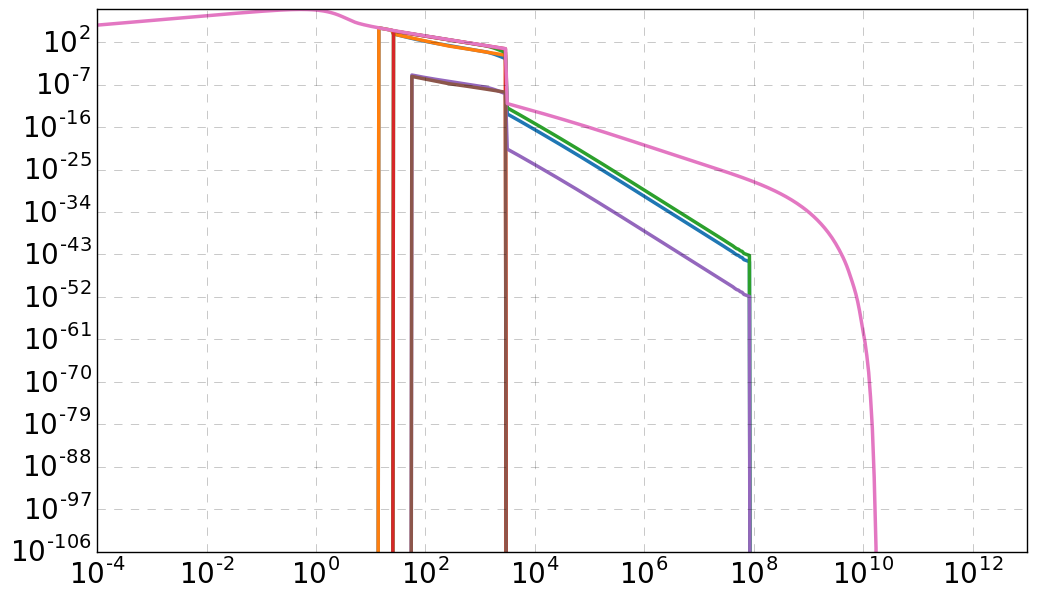

In [11]:
for atom in atoms:
    plt.plot(ionPhotSpec[atom].eng, ionPhotSpec[atom].dNdE)
    lowEngPhotAtomSpec[atom].plot(testInd)
lowEngPhotSpec.plot(testInd)
plt.xscale('log')
plt.yscale('log')


## Ionization Cross Section

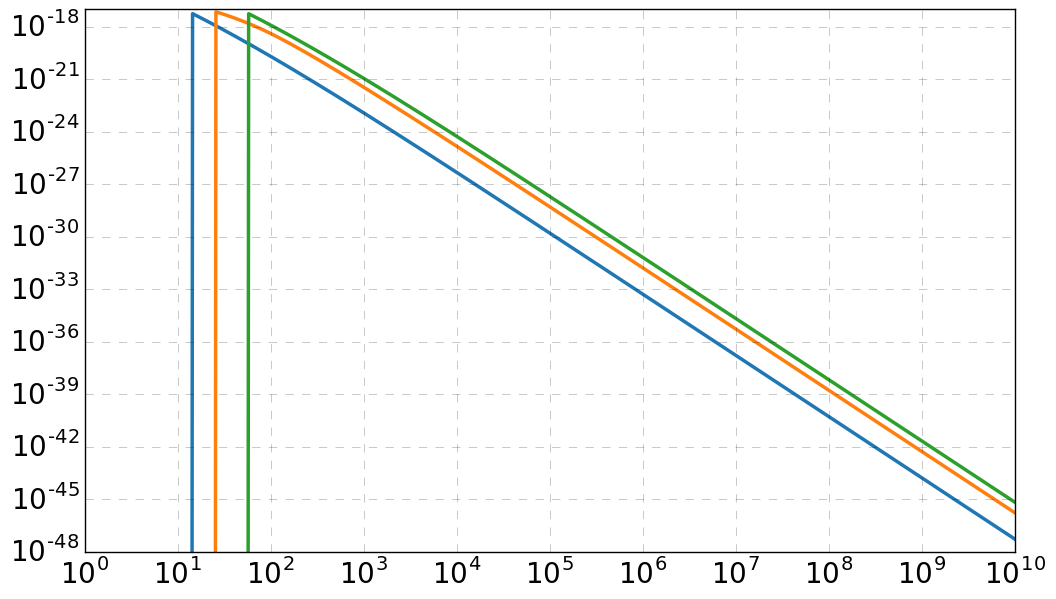

In [12]:
eng = logspace(0,10,num=200)
xsecH0  = photoionxsec(eng,'H0')
xsecHe0 = photoionxsec(eng,'He0')
xsecHe1 = photoionxsec(eng,'He1')

plt.plot(eng,xsecH0)
plt.plot(eng,xsecHe0)
plt.plot(eng,xsecHe1)
plt.xscale('log')
plt.yscale('log')

# Structure Formation

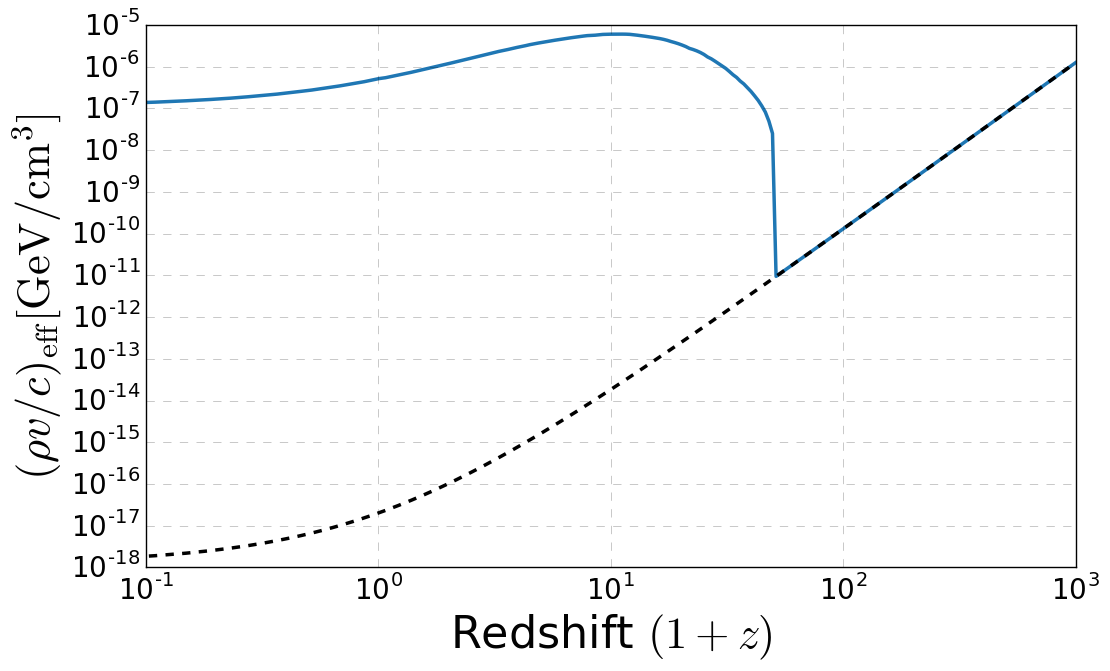

In [9]:
annChan = 'pWave'

structForm = getstructform(annChan,'rho_eff_Einasto_subs')

rsVec = logspace(0,3, num=200)

if annChan == 'sWave':
    yLabelPlot = r'$\rho_\mathrm{eff} [\mathrm{GeV/cm}^3]$'
elif annChan == 'pWave':
    yLabelPlot = r'$(\rho v/c)_\mathrm{eff} [\mathrm{GeV/cm}^3]$'
    
plt.figure(1)
plt.plot(rsVec-1,structForm(rsVec)*1e-9)
plt.plot(rsVec-1,rhoDM*rsVec**3*1e-9*sigma1DNorm(annChan,rsVec),linestyle='dashed',color='black')
plt.xlabel('Redshift '+r'$(1+z)$')
plt.ylabel(yLabelPlot)
plt.xlim([1e-1,1e3])
plt.xscale('log')
plt.yscale('log')

# Three-Level Atom Integration

This part of the code calls the integrator to perform the integration over ionization and thermal histories, given $f(z)$. 

In [15]:
def getfz():
    def fzHIon(rs,xe):
        return (1-xe)/3
    def fzHeIon(rs,xe):
        return 0
    def fzHLya(rs,xe):
        return (1-xe)/3
    def fzHeat(rs,xe):
        return (1+2*xe)/3
    return {'HIon':fzHIon, 'HeIon':fzHeIon, 'HLya':fzHLya, 'Heat':fzHeat}

def getinjrate(injType,injFac):
    def injrate(rs): 
        if injType == 'sWave':
            return injFac*(rs**6)
        elif injType == 'decay':
            return injFac*(rs**3)
    return injrate

initrs = 3000
initCond = [TCMB(initrs), 5]
rsVec = flipud(logspace(1,log10(initrs), num=2000))

ionThermHist = getIonThermHist(initrs,initCond,getfz(),getinjrate('decay',1/1e23),rsVec)
stdIonThermHist = getIonThermHist(initrs,initCond,getfz(),getinjrate('decay',1/1e23),rsVec)


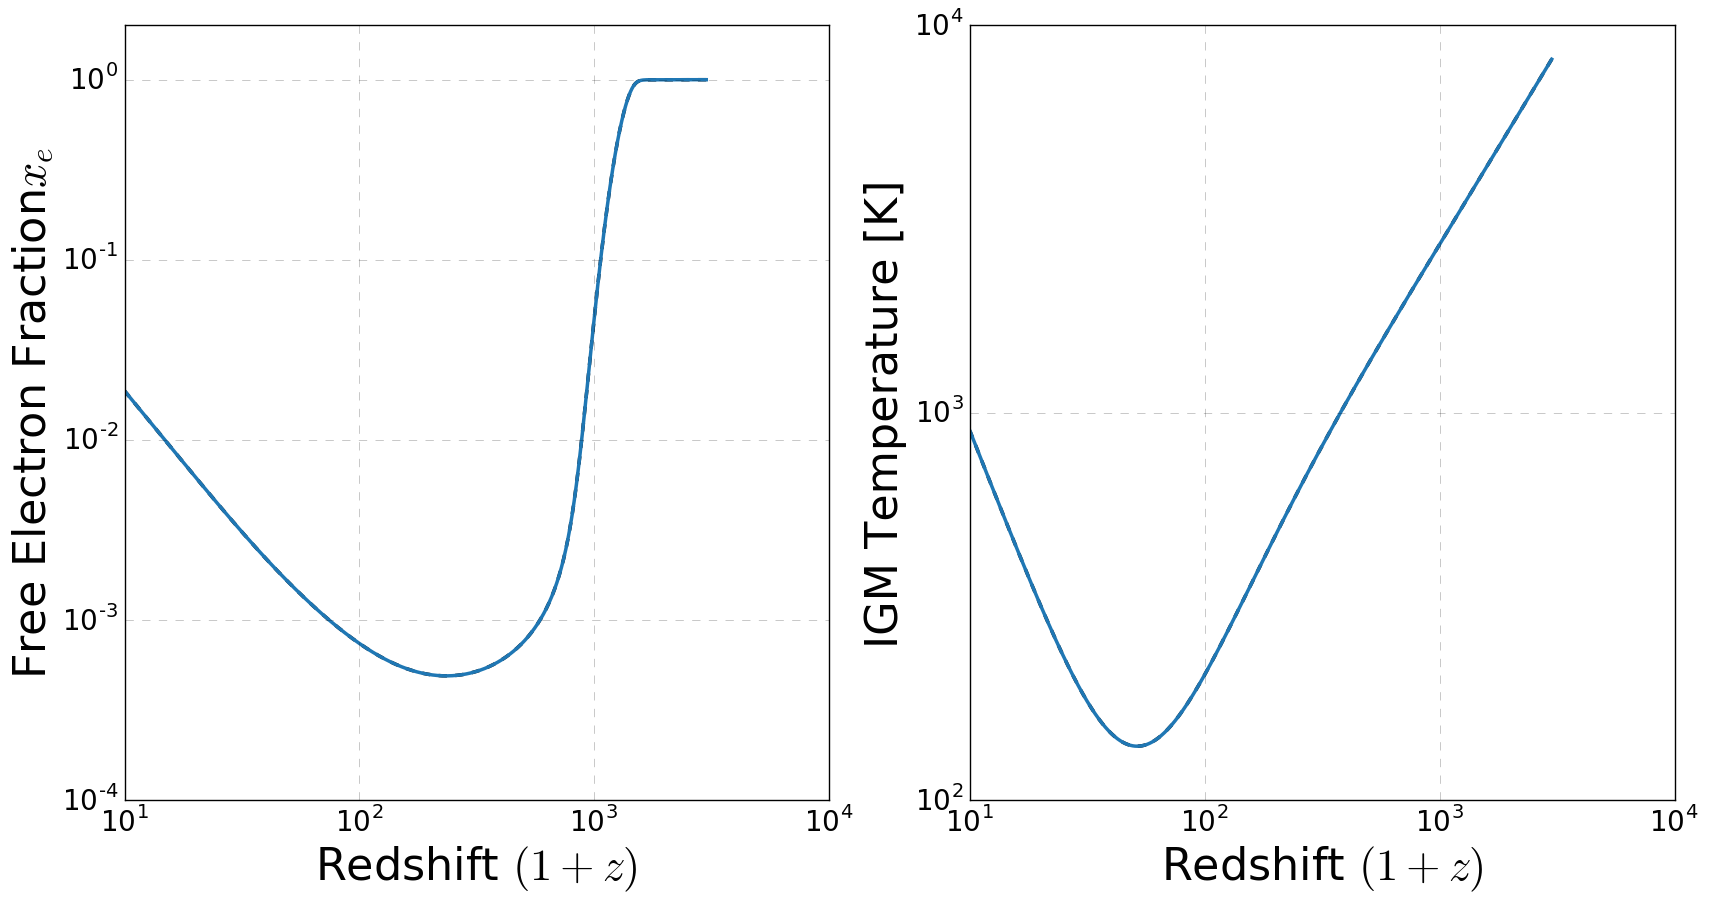

In [16]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.plot(rsVec,0.5+0.5*tanh(stdIonThermHist[:,1]),linestyle='dashed',color='black')
plt.plot(rsVec,0.5+0.5*tanh(ionThermHist[:,1]))
plt.xlabel('Redshift '+r'$(1+z)$')
plt.ylabel('Free Electron Fraction'+r'$x_e$')
plt.ylim([1e-4,2])
plt.xscale('log')
plt.yscale('log')

plt.subplot(122)
plt.plot(rsVec,stdIonThermHist[:,0]/kB,linestyle='dashed',color='black')
plt.plot(rsVec,ionThermHist[:,0]/kB)
plt.xlabel('Redshift $(1+z)$')
plt.ylabel('IGM Temperature [K]')
plt.xscale('log')
plt.yscale('log')

plt.show()